In [2]:
#Import all libraries needed 
import keras 
from keras.datasets import mnist 
from keras.models import Sequential 
from keras import optimizers 
from keras.optimizers import SGD 
from keras.optimizers import adam 
from keras.optimizers import RMSprop 
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten 
from keras import backend as K 
from keras import optimizers 
from keras.preprocessing import image 
from keras.preprocessing.image import ImageDataGenerator 
from keras.preprocessing.image import array_to_img 
from keras.models import load_model 
from keras.callbacks import ReduceLROnPlateau 
from keras.applications import VGG16

import h5py

import os 

import tensorflow as tf 

import numpy as np 
from numpy import array 

from PIL import Image 

from sklearn.model_selection import train_test_split 

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [3]:
#Importing all images for the 8 different classes corresponding to the 8 basic motions required for a human hand in the every-day life

X = []
y=[]

bag_folder = "/Users/Alexandre/Desktop/Alexandre/Machine Learning/TM neural network/Bag/Bag Synset 615"
bowl_folder = "/Users/Alexandre/Desktop/Alexandre/Machine Learning/TM neural network/Bowl/Synset_Bowl_Grayscale 551"
glass_folder="/Users/Alexandre/Desktop/Alexandre/Machine Learning/TM neural network/Glass/Glass Synset 650"
keyboard_folder = "/Users/Alexandre/Desktop/Alexandre/Machine Learning/TM neural network/Keyboard/Keyboard_Synset 718"
knife_folder = "/Users/Alexandre/Desktop/Alexandre/Machine Learning/TM neural network/Knife/Knife Synset 487"
lunettes_folder = "/Users/Alexandre/Desktop/Alexandre/Machine Learning/TM neural network/Lunettes/Lunettes Synset 546"
pen_folder = "/Users/Alexandre/Desktop/Alexandre/Machine Learning/TM neural network/Pen/Pen Synset 708"
telephone_folder = "/Users/Alexandre/Desktop/Alexandre/Machine Learning/TM neural network/Telephone/Telephone_Synset 718"


str_to_num = {"bag" : 0, "bowl" : 1, "glass" : 2, "keyboard" : 3, "knife" : 4, "lunettes" : 5, "pen" : 6, "telephone" : 7 }

def create_data (folder, name):
    count = 0
    for i in os.listdir(folder):
        if i!=".DS_Store":
            
            image = Image.open(os.path.join(folder,i))
           #print(folder)
            #print(i)
            x=np.array(image)
            X.append(x)
            y.append(str_to_num[name])
            count+=1
            if count == 480:
                break


create_data(bag_folder, "bag")
create_data(bowl_folder, "bowl")
create_data(glass_folder, "glass")
create_data(keyboard_folder, "keyboard")
create_data(knife_folder, "knife")
create_data(lunettes_folder, "lunettes")
create_data(pen_folder, "pen")
create_data(telephone_folder, "telephone")
y.count(3)

#Transforming each black and white pixel to a 3D array so that it can be used with the VGG16 pretrained model

NewX = []

for image in X:   
    imagenewx = []
    for i in range (100):
        shortimage = []
        for j in range (100):
            shortimage.append([image[i, j], image[i, j], image[i, j]])
        imagenewx.append(shortimage)
    imagenewx = array(imagenewx)
    imagenewx.reshape(100,100,3) 
    
    NewX.append([imagenewx])

In [4]:
#Turning images and labels into numpy arrays

X = array(NewX)
y = array(y)
X.shape

(3840, 1, 100, 100, 3)

In [5]:
#Creating two distinct sets of training and testing that can be reproduced, 90% (431 images in all classes) of the data will be training data and 10% (49 images 
#in all classes) will be testing data


X_train = []
y_train = []

X_test = []
y_test = []

for i in range (0,8):
    for j in range (0,480):
        if j<=431:
            X_train.append(X[j+i*480])
            y_train.append(y[j+i*480])
        else :
            X_test.append(X[j+i*480])
            y_test.append(y[j+i*480]) 

In [6]:
#Turning all training and testing images and data into numpy arrays

X_train = array(X_train)
X_test = array(X_test)
y_train = array(y_train)
y_test = array(y_test)

In [7]:
#Formating and normalising the data into a form accepted by keras. The normalisation process greatly improves precision while training

if K.image_data_format() == 'channels_first':
    train_images = X_train.reshape(X_train.shape[0], 3, 100, 100)
    test_images = X_test.reshape(X_test.shape[0], 3, 100, 100)
    input_shape = (3, 100, 100)
else:
    train_images = X_train.reshape(X_train.shape[0], 100, 100, 3)
    test_images = X_test.reshape(X_test.shape[0], 100, 100, 3)
    input_shape = (100, 100, 3)
    
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images /= 255
test_images /= 255

In [8]:
#Turning labels to one-hot format

y_train = keras.utils.to_categorical(y_train, 8)
y_test = keras.utils.to_categorical(y_test, 8)

[ 0.  0.  0.  0.  0.  0.  1.  0.]
pen


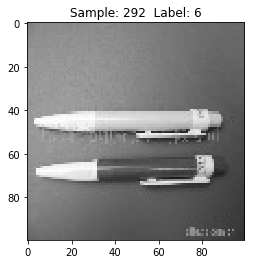

In [9]:
#Displaying the images and their labels

num_to_str =  { 0 : "bag" , 1 : "bowl" , 2 : "glass" , 3 : "keyboard" , 4 : "knife" , 5 : "lunettes", 6 : "pen", 7 : "telephone" }

def display_sample(num):
    #Print the one-hot array of this sample's label 
    print(y_test[num])  
    #Print the label converted back to a number
    label = y_test[num].argmax(axis=0)
    print(num_to_str[label])
    #Reshape the 768 values to a 100x100 image
    image = test_images[num].reshape([100,100,3])
    plt.title('Sample: %d  Label: %s' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()
    
display_sample(292)

In [36]:
#Setting up the Convolutional Neural Network

#Transfer Learning : using VGG16, pretrained with Imagenet

conv_base = VGG16 (weights = "imagenet",
                                    include_top = False , 
                                    input_shape = input_shape)

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dense(8, activation = "sigmoid"))


#Simpler model

"""model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(8, activation = "sigmoid"))"""

#Alexnet

"""
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
# 64 3x3 kernels
model.add(Conv2D(64, (3, 3), activation='relu'))
# Reduce by taking the max of each 2x2 block
model.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout to avoid overfitting
model.add(Dropout(0.25))


# Flatten the results to one dimension for passing into our final layer
model.add(Flatten())
# A hidden layer to learn with
model.add(Dense(128, activation='relu'))
# Another dropout
model.add(Dropout(0.25))
# A hidden layer to learn with
model.add(Dense(128, kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None), activation='relu'))
model.add(Dense(128, kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None), activation='relu'))
model.add(Dense(128, kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None), activation='relu'))
# Final categorization from 0-9 with softmax
model.add(Dense(8, activation='softmax'))
#model.add(Dense(1,activation='sigmoid'))


model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), padding = 'Same', activation='relu', input_shape=input_shape))
# 64 3x3 kernels
model.add(Conv2D(32, kernel_size=(5, 5), padding = 'Same', activation='relu'))
# Reduce by taking the max of each 2x2 block
model.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout to avoid overfitting
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), padding = 'Same', activation='relu', input_shape=input_shape))
# 64 3x3 kernels
model.add(Conv2D(64, kernel_size=(3, 3), padding = 'Same', activation='relu'))
# Reduce by taking the max of each 2x2 block
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
# Dropout to avoid overfitting
model.add(Dropout(0.25))

# Flatten the results to one dimension for passing into our final layer
model.add(Flatten())
# A hidden layer to learn with
model.add(Dense(256, activation='relu'))
# Another dropout
model.add(Dropout(0.5))
# Final categorization from 0-9 with softmax
model.add(Dense(8, activation='softmax'))
#model.add(Dense(1,activation='sigmoid'))"""

"\nmodel = Sequential()\nmodel.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))\n# 64 3x3 kernels\nmodel.add(Conv2D(64, (3, 3), activation='relu'))\n# Reduce by taking the max of each 2x2 block\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\n# Dropout to avoid overfitting\nmodel.add(Dropout(0.25))\n\n\n# Flatten the results to one dimension for passing into our final layer\nmodel.add(Flatten())\n# A hidden layer to learn with\nmodel.add(Dense(128, activation='relu'))\n# Another dropout\nmodel.add(Dropout(0.25))\n# A hidden layer to learn with\nmodel.add(Dense(128, kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None), activation='relu'))\nmodel.add(Dense(128, kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None), activation='relu'))\nmodel.add(Dense(128, kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None), activation='relu'))\n# Final categorization from 0-

In [37]:
#Summarizing and visualising the convolutional base

conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [38]:
#Summarizing and visualising the model

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               1179904   
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 2056      
Total params: 15,896,648
Trainable params: 15,896,648
Non-trainable params: 0
_________________________________________________________________


In [22]:
import pydot
import graphviz
from keras.utils import plot_model
plot_model(conv_base, show_shapes=True, to_file='conv_base.png')
plot_model(conv_base, show_shapes=True, to_file='model.png')

In [40]:
#Freezing of the convolutional base so that it doesn't need to retrain as it would be computationally expensive and would loose the feature extraction that it 
#learned

conv_base.trainable = True
print('This is the number of trainable weights '
         'before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights '
          'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 30


In [41]:
# Compile the model
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

model.compile(optimizer = optimizers.RMSprop(lr = 2e-5) , loss = "categorical_crossentropy", metrics=["accuracy"])
#model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
#sgd = SGD(lr=0.1)
# Define the optimizer
optimizer = adam(lr=0.001)#, rho=0.9, epsilon=1e-08, decay=0.0)
#model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

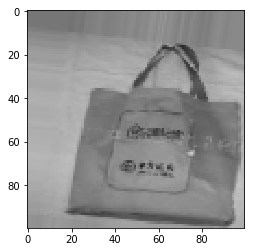

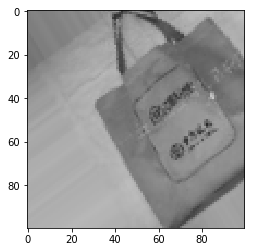

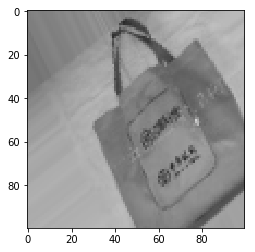

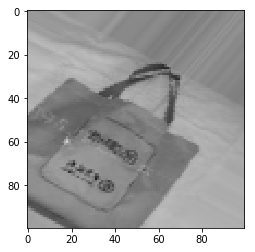

In [24]:
#Showing how we can generate new data from the source data, to create more data for the CNN to train on and thus, be more precise

numero = 3
img_test = train_images[numero]

datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

datagen.fit(train_images)

img_test = img_test.reshape((1,) + img_test.shape)

i=0
for batch in datagen.flow(img_test, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(batch[0])
    i += 1
    if i % 4 == 0:
        break
plt.show()

In [16]:
# Hyperparametres

batch_size=200
epochs = 15

In [17]:
#Models to load

#model.load_weights("Visual_Recognition_CNN_2_v3.h5")

In [18]:
# Compilation of the model

history = model.fit_generator (datagen.flow(train_images, y_train, batch_size = batch_size),
                              steps_per_epoch = 100,
                              epochs = epochs,
                              validation_data = (test_images, y_test),
                              verbose = 2,
                              callbacks = [learning_rate_reduction])

Epoch 1/15
 - 2125s - loss: 1.8998 - acc: 0.3655 - val_loss: 1.6270 - val_acc: 0.5807
Epoch 2/15
 - 2167s - loss: 1.5112 - acc: 0.5479 - val_loss: 1.2566 - val_acc: 0.6693
Epoch 3/15
 - 2161s - loss: 1.2859 - acc: 0.5933 - val_loss: 1.0737 - val_acc: 0.7031
Epoch 4/15
 - 2179s - loss: 1.1573 - acc: 0.6256 - val_loss: 0.9735 - val_acc: 0.7083
Epoch 5/15
 - 2150s - loss: 1.0771 - acc: 0.6493 - val_loss: 0.9068 - val_acc: 0.7266
Epoch 6/15
 - 2166s - loss: 1.0377 - acc: 0.6526 - val_loss: 0.8654 - val_acc: 0.7448
Epoch 7/15
 - 2148s - loss: 0.9962 - acc: 0.6647 - val_loss: 0.8349 - val_acc: 0.7422
Epoch 8/15
 - 2154s - loss: 0.9727 - acc: 0.6745 - val_loss: 0.8169 - val_acc: 0.7344
Epoch 9/15
 - 2177s - loss: 0.9297 - acc: 0.6907 - val_loss: 0.7883 - val_acc: 0.7552
Epoch 10/15
 - 2140s - loss: 0.9148 - acc: 0.6900 - val_loss: 0.7818 - val_acc: 0.7604
Epoch 11/15
 - 2167s - loss: 0.8924 - acc: 0.7000 - val_loss: 0.7574 - val_acc: 0.7630
Epoch 12/15
 - 2155s - loss: 0.8829 - acc: 0.7008 - 

In [ ]:
# Freezing all layers up to a specific one for fine-tuning
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False


In [ ]:
# Fine-tuning the model

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-5), metrics=['acc'])
history = model.fit_generator(steps_per_epoch = 100,
                              epochs = 100,
                              validation_data = (test_images, y_test),
                              verbose = 2,
                              callbacks = [learning_rate_reduction])

In [19]:
#Saving the model

model.save_weights('Visual_Recognition_CNN_2_VGG16_v2.h5')

In [42]:
#Reloading the model (--> not train it each time) to visualize intermediate activations

model.load_weights('/Users/Alexandre/Desktop/Alexandre/Machine Learning/TM neural network/Neural Networks/Weights/Visual_Recognition_CNN_2_VGG16_v1.h5')

In [26]:
#Representing the evolution of accuracy and loss, both on training and testing data

acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history ["loss"]
val_loss = history.history["val_loss"]


epochs = range (1, len(acc)+1)

plt.plot(epochs, acc, "bo", label = "Training Accuracy")
plt.plot(epochs, val_acc, "r", label = "Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs,loss, "bo", label = "Training Loss")
plt.plot(epochs, val_loss, "r", label = "Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.show()

NameError: name 'history' is not defined

In [ ]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [27]:
#Evaluation of the CNN precision

score = model.evaluate(test_images, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.733153792719
Test accuracy: 0.7734375


[[  5.02137336e-05   1.36911360e-04   5.23453753e-04   4.10655469e-01
    2.06510653e-04   2.79740110e-04   3.46435676e-03   5.12050930e-03]]
We predicted :  3  /  keyboard
The actual answer is :  3  /  keyboard


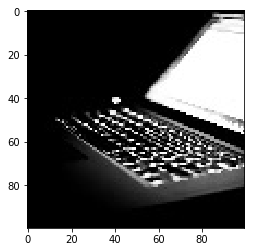

In [148]:
#Testing other data with the model

num_to_str =  { 0 : "bag" , 1 : "bowl" , 2 : "glass" , 3 : "keyboard" , 4 : "knife" , 5 : "lunettes", 6 : "pen", 7 : "telephone" }

scordata=[]
scordata_label = []


more_keyboard_folder = "/Users/Alexandre/Desktop/Alexandre/Machine Learning/TM neural network/Keyboard/More_Keyboard_Synset_500"
telephone_folder = "/Users/Alexandre/Desktop/Alexandre/Machine Learning/TM neural network/Telephone/"
glass_folder="/Users/Alexandre/Desktop/Alexandre/Machine Learning/TM neural network/Glass"


str_to_num = {"bag" : 0, "bowl" : 1, "glass" : 2, "keyboard" : 3, "knife" : 4, "lunettes" : 5, "pen" : 6, "telephone" : 7 }


def create_data (folder, name):
            i="Synset_Bowl_GrayscaleKeyboard1350.jpg"
            image = Image.open(os.path.join(folder,i))
            x=np.array(image)
            scordata.append(x)
            scordata_label.append(str_to_num[name])




create_data(more_keyboard_folder, "keyboard")
scordata = array(scordata)
imagenewx = []
for i in range (100):
    shortimage = []
    for j in range (100):
        shortimage.append([scordata[0, i, j], scordata[0, i, j], scordata[0, i, j]])
    imagenewx.append(shortimage)
imagenewx = array(imagenewx)
imagenewx.reshape(100,100,3) 
scordata = imagenewx
scordata = scordata.reshape(1, 100, 100, 3)
scordata = scordata.astype('float32')
scordata /= 255
scordata_label = keras.utils.to_categorical(scordata_label, 8)


def score ():
    score = model.predict(scordata)
    print(score)
    prediction=0
    a=score[0]
    if a[0] > max( a[1] , a[2], a[3], a[4], a[5], a[6], a[7]) :
        prediction=0
    if a[1] > max( a[0] , a[2], a[3], a[4], a[5], a[6], a[7]):
        prediction=1
    if a[2] > max( a[1] , a[0], a[3], a[4], a[5], a[6], a[7]):
        prediction=2
    if a[3] > max( a[1] , a[2], a[0], a[4], a[5], a[6], a[7]):
        prediction=3
    if a[4] > max( a[1] , a[2], a[3], a[0], a[5], a[6], a[7]):
        prediction=4
    if a[5] > max( a[1] , a[2], a[3], a[4], a[0], a[6], a[7]):
        prediction=5
    if a[6] > max( a[1] , a[0], a[3], a[4], a[5], a[0], a[7]):
        prediction=6
    if a[7] > max( a[1] , a[0], a[3], a[4], a[5], a[6], a[0]):
        prediction=7
    
    print("We predicted : ", prediction, " / ", num_to_str[prediction])   
    print("The actual answer is : ", scordata_label[0].argmax(axis=0), " / ", num_to_str[scordata_label[0].argmax(axis=0)])
    
score()
plt.imshow(scordata[0])
plt.show() 

In [ ]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

===========Filters from the first layer===========


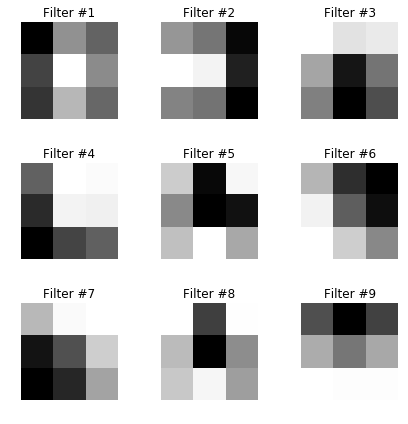

In [163]:
columns = 3
rows = 3
fig=plt.figure(figsize=(rows*2, columns*2))
top_layer = model.layers[0]
print("Filters from the first layer".center(50, '='))
for i in range (1, rows*columns+1):
    filter_visualized = array(top_layer.get_weights()[0][:, :, :, i].squeeze())
    filter_visualized = rgb2gray(filter_visualized)
    fig.add_subplot(rows, columns, i)
    plt.axis("off")
    plt.title("Filter #" + str(i))
    plt.imshow(filter_visualized, cmap='gray')   
plt.tight_layout()
plt.show()

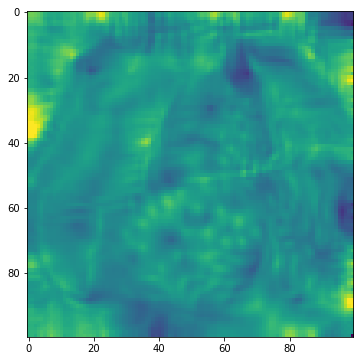

In [43]:
from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

# Utility to search for layer index by name.
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'dense_4')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

# This is the output node we want to maximize.
filter_idx = 0
img = visualize_activation(model, layer_idx, filter_indices=filter_idx)
plt.imshow(img[..., 0])

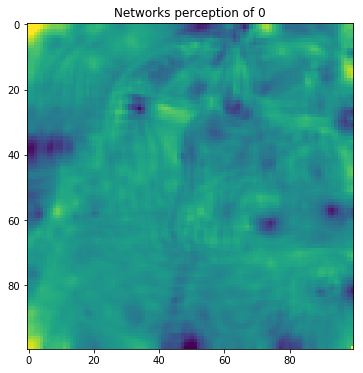

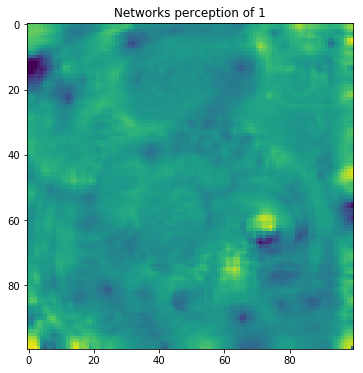

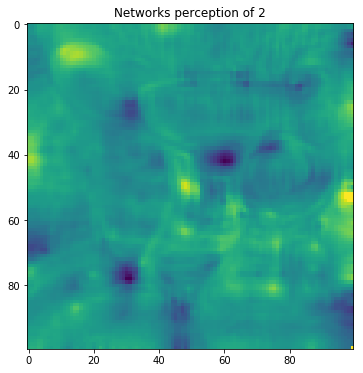

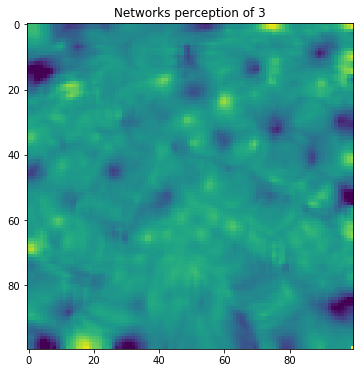

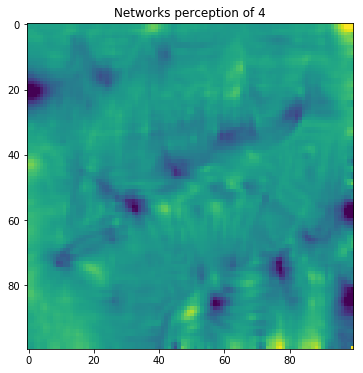

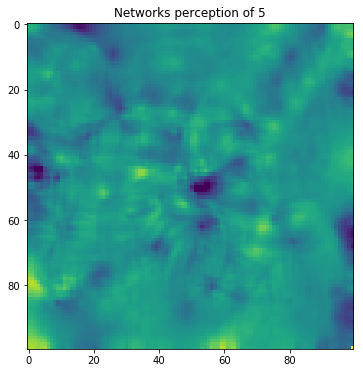

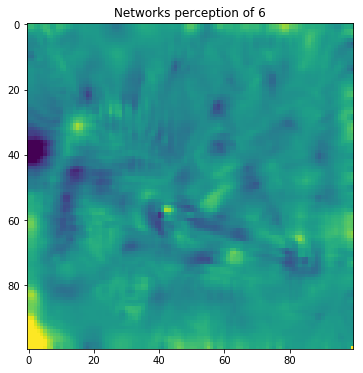

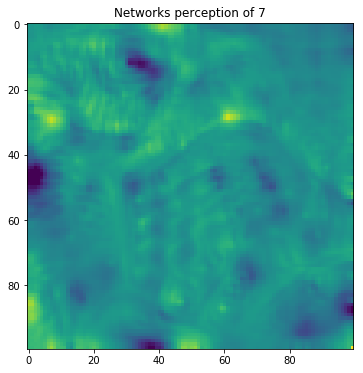

In [169]:
try :
    for output_idx in np.arange(10):
        # Lets turn off verbose output this time to avoid clutter and just see the output.
        img = visualize_activation(model, layer_idx, filter_indices=output_idx, input_range=(0., 1.))
        plt.figure()
        plt.title('Networks perception of {}'.format(output_idx))
        plt.imshow(img[..., 0])
except :
    pass

In [29]:
def iter_occlusion(image, size=8):
    # taken from https://www.kaggle.com/blargl/simple-occlusion-and-saliency-maps

    occlusion = np.full((size * 5, size * 5, 1), [0.5], np.float32)
    occlusion_center = np.full((size, size, 1), [0.5], np.float32)
    occlusion_padding = size * 2

   # print('padding...')
    image_padded = np.pad(image, ( \
    (occlusion_padding, occlusion_padding), (occlusion_padding, occlusion_padding), (0, 0) \
    ), 'constant', constant_values = 0.0)

    for y in range(occlusion_padding, image.shape[0] + occlusion_padding, size):

        for x in range(occlusion_padding, image.shape[1] + occlusion_padding, size):
            tmp = image_padded.copy()

            tmp[y - occlusion_padding:y + occlusion_center.shape[0] + occlusion_padding, \
             x - occlusion_padding:x + occlusion_center.shape[1] + occlusion_padding] \
             = occlusion

            tmp[y:y + occlusion_center.shape[0], x:x + occlusion_center.shape[1]] = occlusion_center

            yield x - occlusion_padding, y - occlusion_padding, \
             tmp[occlusion_padding:tmp.shape[0] - occlusion_padding, occlusion_padding:tmp.shape[1] - occlusion_padding]

i = 23 # for example
data = train_images[i]
correct_class = np.argmax(y_train[i])

# input tensor for model.predict
inp = data.reshape(1, 100, 100, 3)

# image data for matplotlib's imshow
img = data.reshape(100, 100, 3)

# occlusion
img_size = img.shape[0]
occlusion_size = 4

print('occluding...')

heatmap = np.zeros((img_size, img_size), np.float32)
class_pixels = np.zeros((img_size, img_size), np.int16)

from collections import defaultdict
counters = defaultdict(int)

for n, (x, y, img_float) in enumerate(iter_occlusion(data, size=occlusion_size)):

    X = img_float.reshape(1, 100, 100, 3)
    out = model.predict(X)
    #print('#{}: {} @ {} (correct class: {})'.format(n, np.argmax(out), np.amax(out), out[0][correct_class]))
    #print('x {} - {} | y {} - {}'.format(x, x + occlusion_size, y, y + occlusion_size))

    heatmap[y:y + occlusion_size, x:x + occlusion_size] = out[0][correct_class]
    class_pixels[y:y + occlusion_size, x:x + occlusion_size] = np.argmax(out)
    counters[np.argmax(out)] += 1

occluding...


In [171]:
class_idx = 0
indices = np.where(val_y[:, class_idx] == 1.)[0]

# pick some random input from here.
idx = indices[0]

# Lets sanity check the picked image.
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

plt.imshow(val_x[idx][..., 0])


from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'preds')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, seed_input=val_x[idx])
# Plot with 'jet' colormap to visualize as a heatmap.
plt.imshow(grads, cmap='jet')


# This corresponds to the Dense linear layer.
for class_idx in np.arange(10): 
    indices = np.where(val_y[:, class_idx] == 1.)[0]
    idx = indices[0]

    f, ax = plt.subplots(1, 4)
    ax[0].imshow(val_x[idx][..., 0])
 
    for i, modifier in enumerate([None, 'guided', 'relu']):
        grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, 
        seed_input=val_x[idx], backprop_modifier=modifier)
        if modifier is None:
            modifier = 'vanilla'
        ax[i+1].set_title(modifier) 
        ax[i+1].imshow(grads, cmap='jet')

NameError: name 'val_y' is not defined

In [34]:
from vis.visualization import visualize_cam

# This corresponds to the Dense linear layer.
for class_idx in np.arange(8): 
    indices = np.where(y_train[:, class_idx] == 1.)[0]
    idx = indices[0]

f, ax = plt.subplots(1, 4)
ax[0].imshow(train_images[idx][..., 0])
 
for i, modifier in enumerate([None, 'guided', 'relu']):
    grads = visualize_cam(model, layer_idx, filter_indices=class_idx, 
    seed_input=val_x[idx], backprop_modifier=modifier) 
    if modifier is None:
        modifier = 'vanilla'
    ax[i+1].set_title(modifier) 
    ax[i+1].imshow(grads, cmap='jet')

NameError: name 'layer_idx' is not defined

Results :

Activation :             adam 20 epochs, batch_size=80 : best epoch : Epoch 19/20 - 61s - loss: 0.0060 - acc: 0.9974 - val_loss: 2.8445 - val_acc: 0.5923

                                adam 10 epochs, batch_size=80 : best epoch : Epoch 4/10 - 62s - loss: 0.6707 - acc: 0.7135 - val_loss: 0.9716 - val_acc: 0.5769

                               rmsprop :  20 epochs, batch_size=80 : best epoch :  Epoch 19/20 - 52s - loss: 0.0084 - acc: 0.9987 - val_loss: 2.5612 - val_acc: 0.6256
                               
                               sgd : 20 epochs, batch_size=80 : best epoch : Epoch 14/20 - 70s - loss: 0.0044 - acc: 0.9994 - val_loss: 2.6060 - val_acc: 0.6308
                               
                                sgd with https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6Epoch 9/10 - 143s - loss: 1.0069 - acc: 0.5032 -                                     val_loss: 1.0143 - val_acc: 0.4769

Activation with all data : Adam 10 epochs, batch_size=80 : best epoch : Epoch 8/10 - 118s - loss: 0.2739 - acc: 0.9238 - val_loss: 2.1514 - val_acc: 0.4206
                                       Adam 10 epochs, batch_size=80 : best epoch : Epoch 10/10 - 136s - loss: 0.1045 - acc: 0.9740 - val_loss: 2.7898 - val_acc: 0.4115
                                       Adam 10 epochs, batch_size=80 with https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6Epoch : Epoch                                          10/10 - 198s - loss: 0.6615 - acc: 0.7715 - val_loss: 2.1111 - val_acc: 0.4076
                                       Rmsprop : 10 epochs, batch_size=80 : best epoch : Epoch 7/10 - 93s - loss: 0.3604 - acc: 0.8981 - val_loss: 2.2180 - val_acc: 0.4049
                                       SGD : Epoch 10/10 - 90s - loss: 1.9566 - acc: 0.2402 - val_loss: 1.9558 - val_acc: 0.2565
                                       Adam 10 epochs, batch_size=200 : best epoch : Epoch 10/10 - 99s - loss: 0.3021 - acc: 0.9167 - val_loss: 2.0850 - val_acc: 0.4336
                                       Rmsprop (lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0) with learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',                                                    patience=3, verbose=1, factor=0.5, min_lr=0.00001): 25 epochs, batch_size=200 : Epoch 25/25 - 116s - loss: 0.0265 - acc: 0.9935 -                                              val_loss: 3.5402 - val_acc: 0.4128
                                       Adam (lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0) with learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',                                                        patience=3, verbose=1, factor=0.5, min_lr=0.00001): 25 epochs, batch_size=200 : Epoch 25/25 - 100s - loss: 0.0068 - acc: 0.9987 -                                              val_loss: 3.9419 - val_acc: 0.3880
                                       Adam 10 epochs with 4 hidden layers, batch_size=200 : best epoch : Epoch 10/10 - 113s - loss: 1.2932 - acc: 0.5394 - val_loss: 1.7627                                        - val_acc: 0.3945
                                       Adam 10 epochs with weight initialization, truncated_normal, batch_size=200 : best epoch :Epoch 10/10 - 125s - loss: 0.4715 - acc:                                            0.8581 - val_loss: 2.1928 - val_acc: 0.3997